<img src="files/model_1_outline.png">

sequence generator shape (corrected) (b, n, w, h, c)

## Changes: 
### Use camera 2
### Trim to 2 seconds

In [1]:
import os
import glob
import keras

In [2]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime

In [3]:
# from patrice's blogpost
from keras_video import VideoFrameGenerator

In [4]:
classes = ['suture_throws', 'hand_ties', 'thread_cuts']
classes.sort()
print(classes)

['hand_ties', 'suture_throws', 'thread_cuts']


In [5]:
# some global params
SIZE = (100, 100) # height and width of frame pxl by pxl
CHANNELS = 3 # RGB or whatever
NBFRAME = 5 # num frames in sequence 
BS = 8 # Batch size

In [6]:
# pattern to get videos and classes
glob_pattern='../data_v2_1_model_1_2/model_data/{classname}/*.avi'

In [7]:
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

In [11]:
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

class hand_ties, validation count: 129, train count: 264
class suture_throws, validation count: 129, train count: 264
class thread_cuts, validation count: 129, train count: 264
Total data: 3 classes for 792 files for train


In [12]:
# getting validation data
valid = train.get_validation_generator()

Total data: 3 classes for 387 files for validation


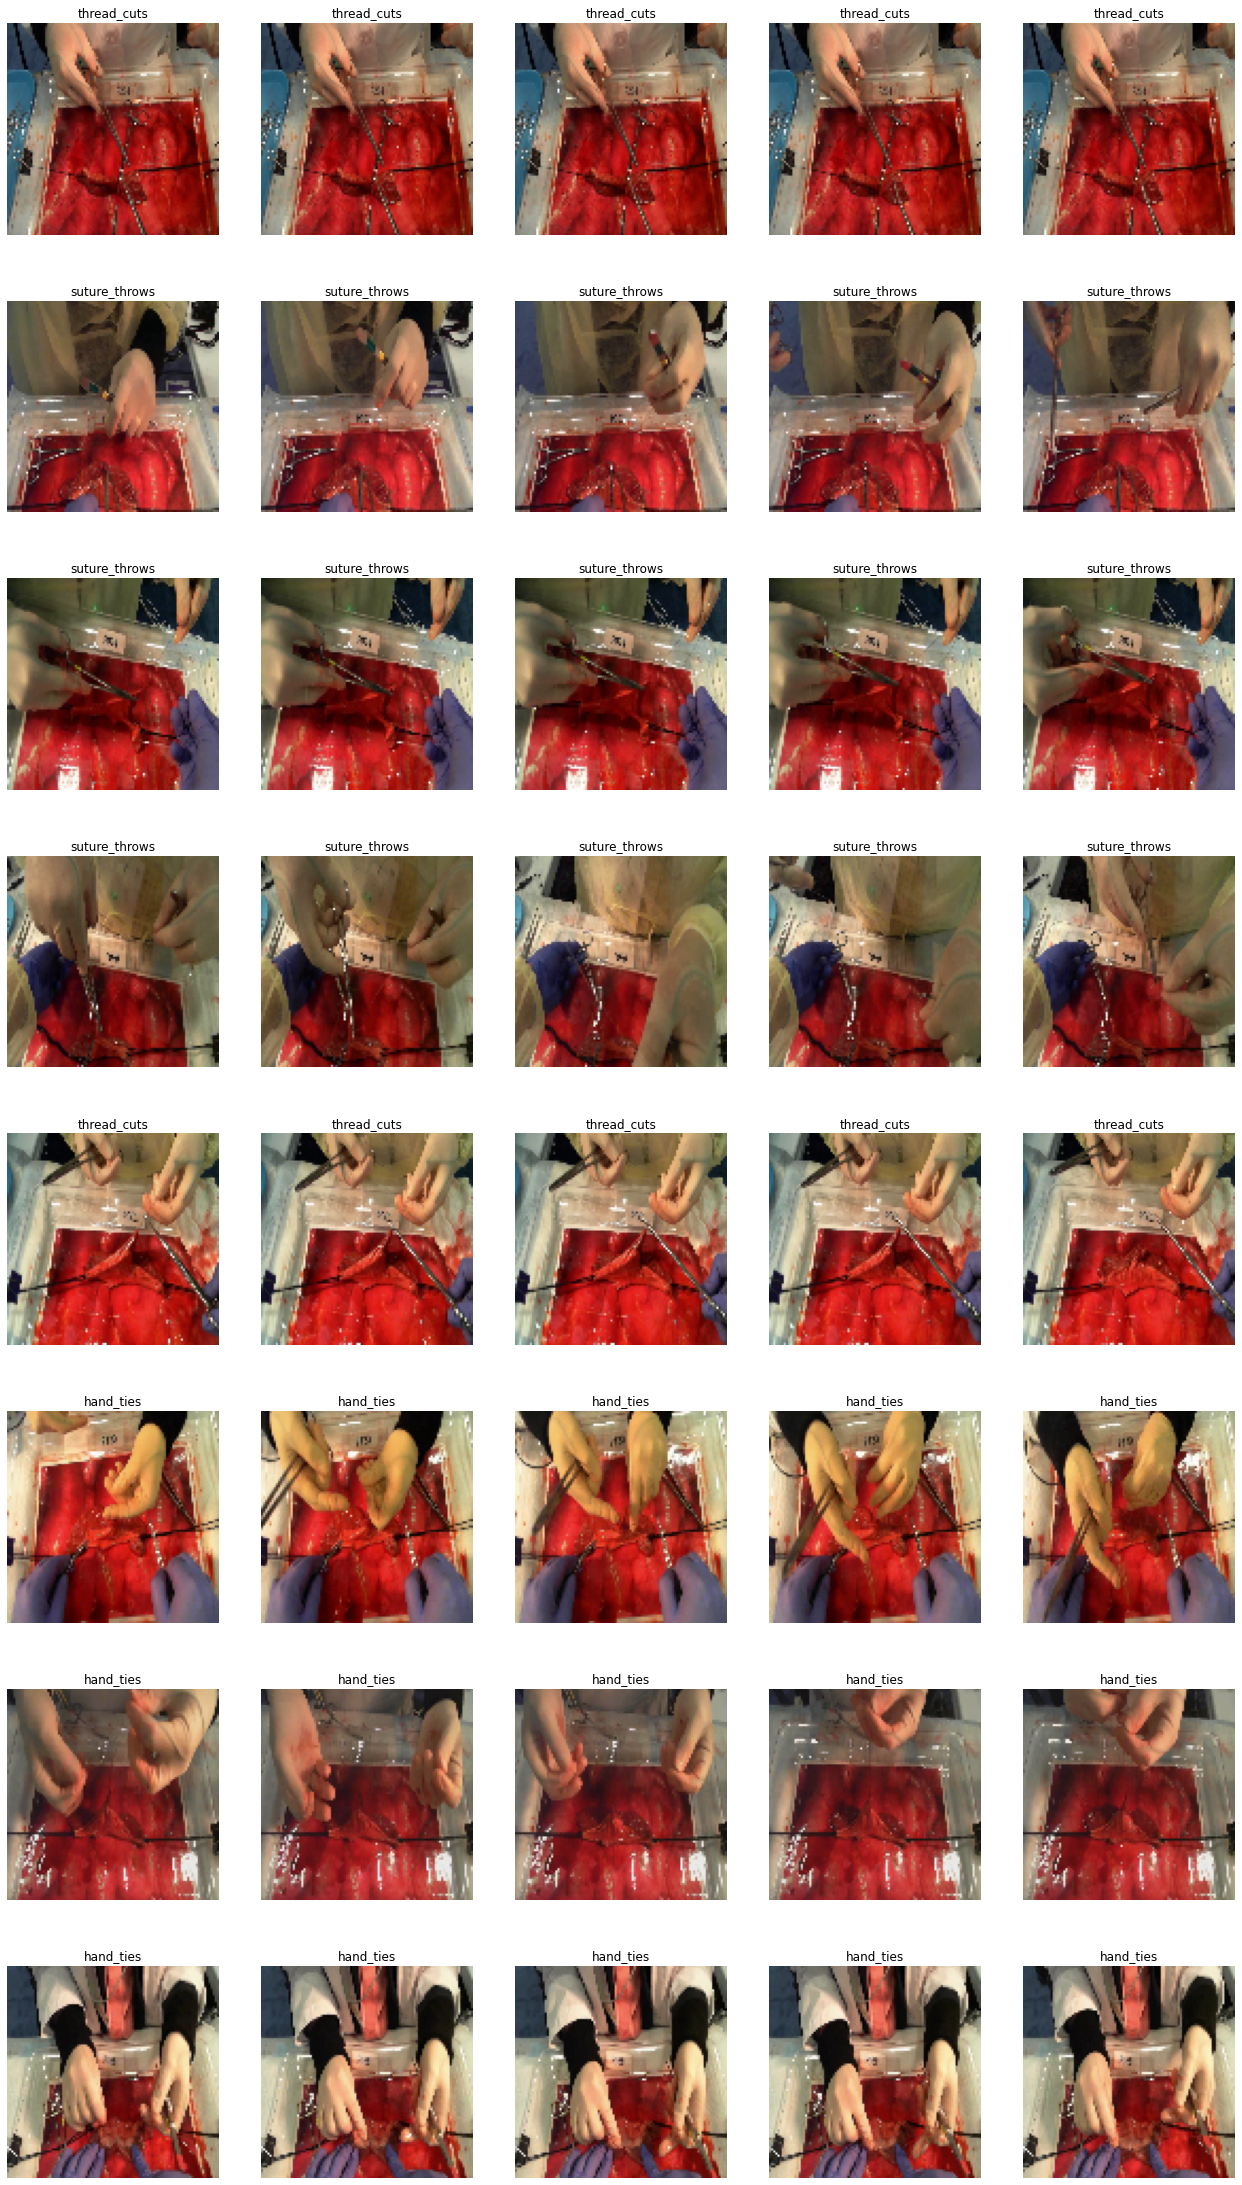

In [13]:
import keras_video.utils
keras_video.utils.show_sample(train)

## BUILD CONV NET

In [14]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    # specify momentum
    momentum = .9
    # create the model from 9=(what is sequential: not clear, just a basic layer stacker class)
    model = keras.Sequential()
    # builds a 2D convnet, filter #, filter size ...
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    
    # same takes in previous layer, I guess
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    # adding batch normalization (forgot what batch normalization is used for)
    model.add(BatchNormalization(momentum=momentum))
    
    # max pool to this layer
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten... (not sure why not flatten instead of GlobalMaxPool2D)
    model.add(GlobalMaxPool2D())
    return model

 64 filters (3x3, same, relu) --> 64 filters (3x3, same, relu) --> BatchNorm with momentum --> maxpool --> 128 filters (3x3, same, relu) --> 128 filters (3x3, same, relu) --> BatchNorm, momentum -> 256 filters (3x3, same, relu) --> 256 filters (3x3, same, relu) --> BatchNorm, Momentum --> max pool --> 512 filters (3x3, same, relu) --> 512 filters (3x3, same, relu) --> Batch norm --> Flatten

## Build GRU

In [15]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
# Shape (5, 112, 112, 3) 5 - time sequence length 112x112 = height vs width 3 - num channels
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    # KEY = allows you to add a time sequence to a layer one at a time
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

## this is where you tell the model how to train - loss function, weight update mechanism

In [16]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# action model - GRU set up for Time shifted CNN
model = action_model(INSHAPE, len(classes))

# this is where you tell the model how to train - loss function, weight update mechanism
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

## epochs, call backs

In [19]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
EPOCHS=10
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'model1_1_chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]
)

Epoch 1/10
99/99 [==============================] - 576s 6s/step - loss: 1.1356 - acc: 0.3497 - val_loss: 1.1040 - val_acc: 0.3359
Epoch 2/10
99/99 [==============================] - 364s 4s/step - loss: 1.1346 - acc: 0.3333 - val_loss: 1.0916 - val_acc: 0.3177
Epoch 3/10
99/99 [==============================] - 363s 4s/step - loss: 1.1144 - acc: 0.3674 - val_loss: 1.0896 - val_acc: 0.3698
Epoch 4/10
99/99 [==============================] - 364s 4s/step - loss: 1.1142 - acc: 0.3207 - val_loss: 1.0871 - val_acc: 0.4089
Epoch 5/10
99/99 [==============================] - 365s 4s/step - loss: 1.1038 - acc: 0.3384 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 6/10
99/99 [==============================] - 363s 4s/step - loss: 1.1087 - acc: 0.3283 - val_loss: 1.0989 - val_acc: 0.3333
Epoch 7/10
99/99 [==============================] - 371s 4s/step - loss: 1.1053 - acc: 0.3321 - val_loss: 1.0984 - val_acc: 0.3385
Epoch 8/10
99/99 [==============================] - 365s 4s/step - loss: 1.1040 - a